### DONT FORGET TO SWITCH KERNEL TO GPU!!!

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.0.0
Default GPU Device: /device:GPU:0


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import pickle
import numpy as np

# graph visualization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.__version__

Using TensorFlow backend.


'2.3.1'

In [35]:
def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))
        
def compare_mlp_cnn_tr(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(45,20))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

### TRAFFIC DATA

In [5]:
file_train = open("./data/traffic/train.pickle", "rb")
data_train = pickle.load(file_train) 
file_test = open("./data/traffic/test.pickle", "rb")
data_test = pickle.load(file_test) 
file_val = open("./data/traffic/test.pickle", "rb")
data_val = pickle.load(file_val) 

In [54]:
data_train.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [51]:
for i in data_train['size']:
    print(i)

array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 199, 200, 201, 203, 205, 207, 208, 211, 213, 21

In [6]:
data_train['features'].shape

(34799, 32, 32, 3)

In [46]:
data_test['features'].shape

(12630, 32, 32, 3)

In [47]:
data_val['features'].shape

(12630, 32, 32, 3)

In [ ]:
X_train = data_train['features']
X_test = data_test['features']
y_train = data_train['labels']
y_test = data_test['labels']

### TRAFFIC PREPROCESS

In [103]:
# select random images to visualize
import random
random.seed(1)

# function to plot images in grid like fashion
def plot_gallery(images, title, h, w, n_row=4, n_col=8):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    rand_sample = random.sample(range(0,images.shape[0]), k=32)
    n = 0
    for i in rand_sample:
        plt.subplot(n_row, n_col, n + 1)
        plt.imshow(images[i][0])
        plt.title(title[i], size=12)
        plt.xticks(())
        plt.yticks(())
        n = n+1

In [73]:
file = open("./data/traffic/data3.pickle", "rb")
data = pickle.load(file) 

In [74]:
X_train_tr = data['x_train']
X_test_tr = data['x_test']
y_train_tr = data['y_train']
y_test_tr = data['y_test']

In [95]:
np.transpose(X_train_tr[500], (2, 1, 0)).shape

(32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


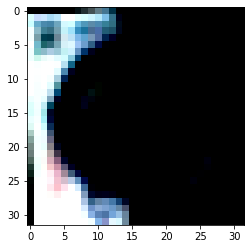

In [102]:
# np.transpose(img, (1, 2, 0))

plt.imshow(np.transpose(X_train_tr[500], (2, 1, 0)), interpolation='nearest')

# plt.imshow(X_train_tr[500][2], interpolation='nearest')


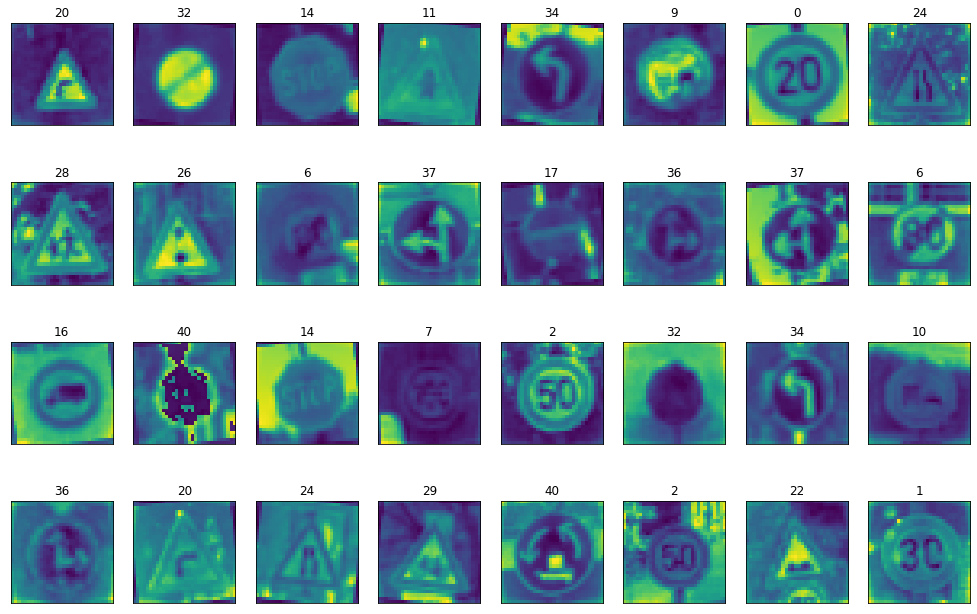

In [104]:
# WARNING WARNING WARNING
# OUR IMAGES HAVE BEEN PREPROCESSED THUS WE CANNOT ACCESS THE IMAGES TO DISPLAY THEM SINCE 
# THEY ARE ALL MESSED UP (SEE ABOVE IMG). BELOW SIMPLY SHOWS 1 CHANNEL OF THE IMAGE AS SEEN IN
# FUNC ABOVE...
plot_gallery(X_train_tr, y_train_tr,32,32)

In [45]:
X_train_tr.shape

(86989, 1, 32, 32)

In [46]:
X_train_tr[0].shape

(1, 32, 32)

In [47]:
%%time

## QUESTIONS ##
'''
1. Is the way we are feeding data into CNN correct?
2. Reccomendations on structures that will work well with our data? How to go about constructing them?
3. Which params exactly are the ones we should tune?
4. How would we go about data expansion if we use the preprocessed pickle files? Can we perform on data8
   which has shuffling, histogram equalization, and mean + std normalization? (not flattened)
5. Ask about which activation functions should be linear or relu
6. If we use the "validation_data" param, as seen below (curently uses the test data to validate), do we 
   need to use a third validation data set? If so, then where do we predict that? After the fit?
'''

img_wh = 32 # width and height of Fashion MNIST images

y_train_ohe_tr = keras.utils.to_categorical(y_train_tr, 43)
y_test_ohe_tr = keras.utils.to_categorical(y_test_tr, 43)

# changes: |
#    1. Baseline: 2 conv layers and two output layers
cnn1 = Sequential()
# cnn1.add( Reshape((3,img_wh, img_wh), input_shape=(1,img_wh**2)) )

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters, 
                     kernel_size=(3,3), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    

# add one layer on flattened output
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(43, activation='softmax') )

# Let's train the model 
cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

#we need to exapnd the dimensions here to give the 
#  "channels" dimension expected by Keras
cnn1.fit(X_train_tr, y_train_ohe_tr, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(X_test_tr,y_test_ohe_tr),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

Train on 86989 samples, validate on 12630 samples
Epoch 1/15
86989/86989 [==============================] - 11s 125us/step - loss: 0.0052 - accuracy: 0.8313 - val_loss: 0.0040 - val_accuracy: 0.8857
Epoch 2/15
86989/86989 [==============================] - 11s 125us/step - loss: 0.0012 - accuracy: 0.9653 - val_loss: 0.0025 - val_accuracy: 0.9325
Epoch 3/15
86989/86989 [==============================] - 11s 123us/step - loss: 7.6903e-04 - accuracy: 0.9787 - val_loss: 0.0024 - val_accuracy: 0.9346
Epoch 4/15
86989/86989 [==============================] - 11s 122us/step - loss: 6.0761e-04 - accuracy: 0.9833 - val_loss: 0.0027 - val_accuracy: 0.9279
Epoch 5/15
86989/86989 [==============================] - 11s 123us/step - loss: 5.1510e-04 - accuracy: 0.9858 - val_loss: 0.0024 - val_accuracy: 0.9364
Epoch 6/15
86989/86989 [==============================] - 11s 122us/step - loss: 4.3569e-04 - accuracy: 0.9884 - val_loss: 0.0025 - val_accuracy: 0.9361
Epoch 7/15
86989/86989 [================

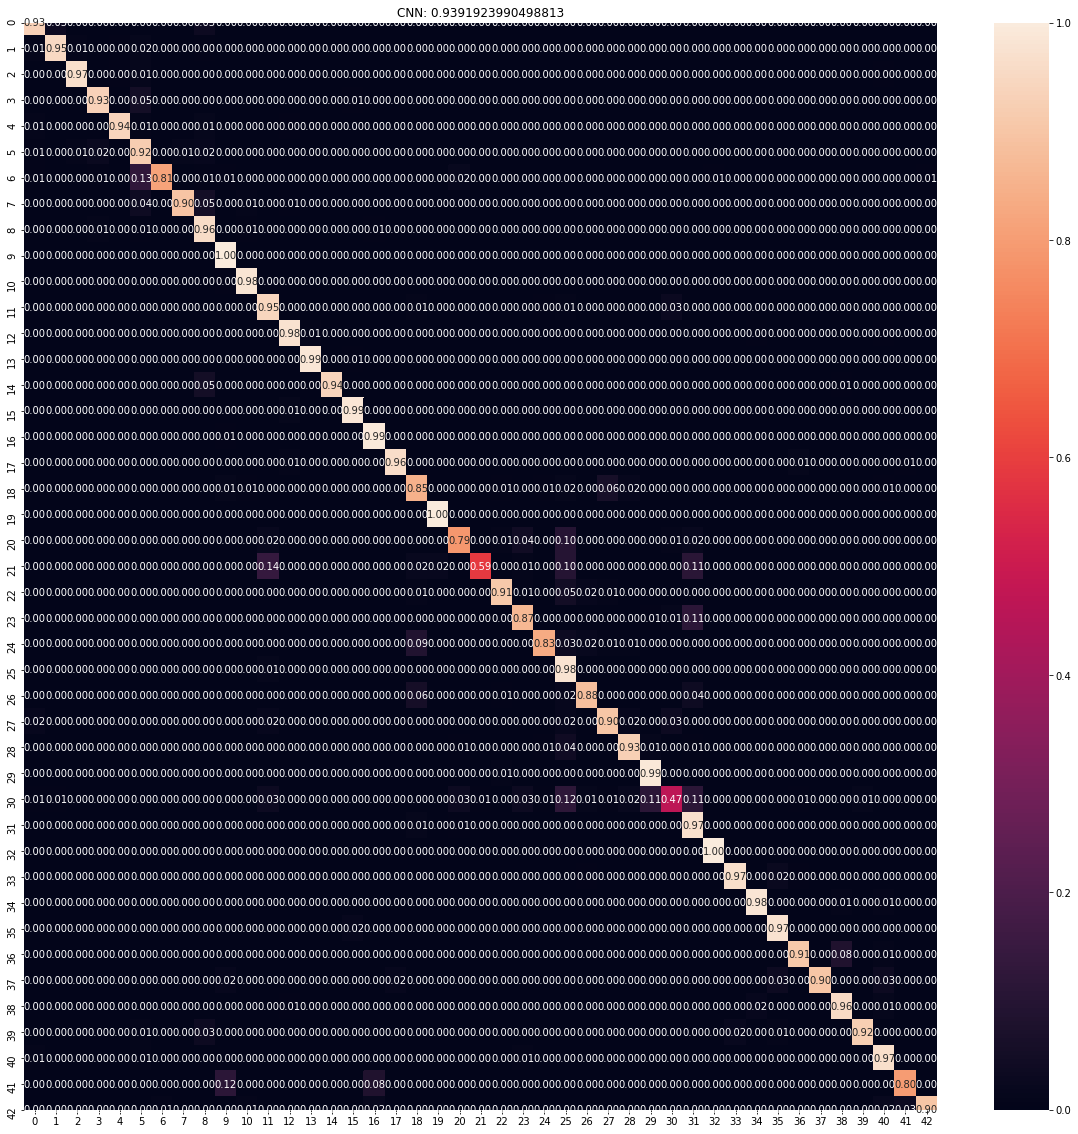

In [48]:
compare_mlp_cnn_tr(cnn1,None,X_test_tr,y_test_tr)

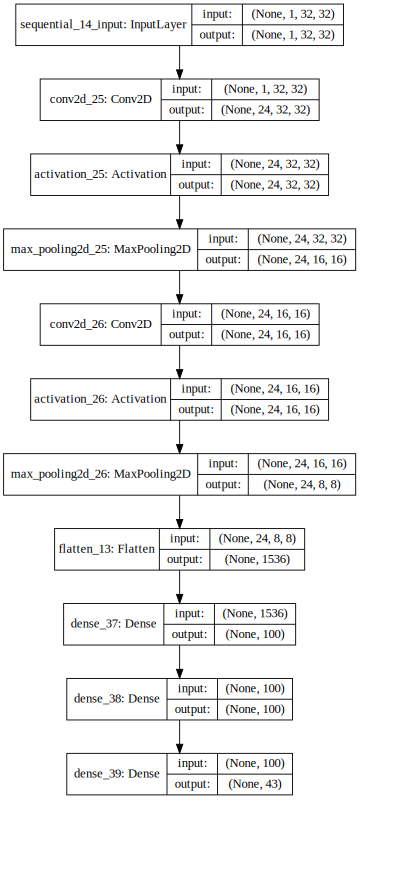

In [49]:
SVG(model_to_dot(cnn1, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

### MNIST

In [5]:
# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='fashion_train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train_MN, y_train_MN = load_mnist('data/', kind='fashion_train')
print('Rows: %d, columns: %d' % (X_train_MN.shape[0], X_train_MN.shape[1]))

X_test_MN, y_test_MN = load_mnist('data/', kind='fashion_t10k')
print('Rows: %d, columns: %d' % (X_test_MN.shape[0], X_test_MN.shape[1]))
X_train_MN = X_train_MN/255.0 - 0.5
X_test_MN = X_test_MN/255.0 - 0.5

NUM_CLASSES = 10

y_train_MN.shape

Rows: 60000, columns: 784
Rows: 10000, columns: 784


(60000,)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 7s 120us/step - loss: 0.0227 - accuracy: 0.8393 - val_loss: 0.0227 - val_accuracy: 0.8409
Epoch 2/15
60000/60000 [==============================] - 7s 117us/step - loss: 0.0154 - accuracy: 0.8953 - val_loss: 0.0151 - val_accuracy: 0.8955
Epoch 3/15
60000/60000 [==============================] - 7s 118us/step - loss: 0.0134 - accuracy: 0.9090 - val_loss: 0.0145 - val_accuracy: 0.9010
Epoch 4/15
60000/60000 [==============================] - 7s 117us/step - loss: 0.0121 - accuracy: 0.9179 - val_loss: 0.0135 - val_accuracy: 0.9060
Epoch 5/15
60000/60000 [==============================] - 7s 118us/step - loss: 0.0112 - accuracy: 0.9248 - val_loss: 0.0143 - val_accuracy: 0.9038
Epoch 6/15
60000/60000 [==============================] - 7s 119us/step - loss: 0.0103 - accuracy: 0.9310 - val_loss: 0.0144 - val_accuracy: 0.9037
Wall time: 43.7 s


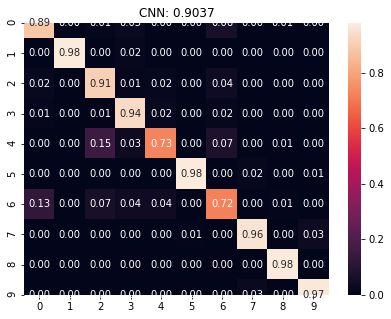

In [10]:
%%time

img_wh = 28 # width and height of Fashion MNIST images

y_train_ohe_MN = keras.utils.to_categorical(y_train_MN, NUM_CLASSES)
y_test_ohe_MN = keras.utils.to_categorical(y_test_MN, NUM_CLASSES)

# changes: 
#    1. Baseline: 2 conv layers and two output layers
cnn1 = Sequential()
cnn1.add( Reshape((1,img_wh, img_wh), input_shape=(1,img_wh**2)) )

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters, 
                     kernel_size=(3,3), 
                     padding='same',
                     data_format="channels_first") 
            )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    

# add one layer on flattened output
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

#we need to exapnd the dimensions here to give the 
#  "channels" dimension expected by Keras
cnn1.fit(np.expand_dims(X_train_MN, axis=1), y_train_ohe_MN, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(np.expand_dims(X_test_MN, axis=1),y_test_ohe_MN),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

compare_mlp_cnn(cnn1,None,X_test_MN,y_test_MN)

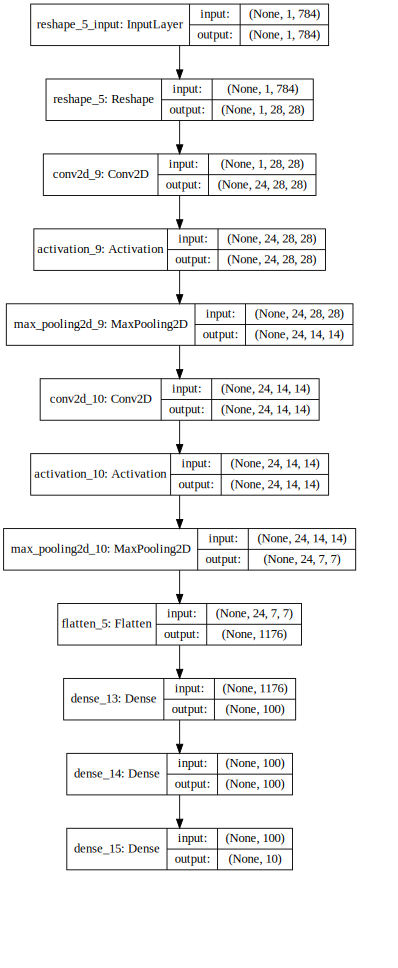

In [16]:
SVG(model_to_dot(cnn1, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))